In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#logistic regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

#model assessment
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
#Planning to use logistic regression, KNN, Random Forest


In [16]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head()

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8
3,0,1,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3
4,1,0,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18


<h2> Classes are inherently imbalanced

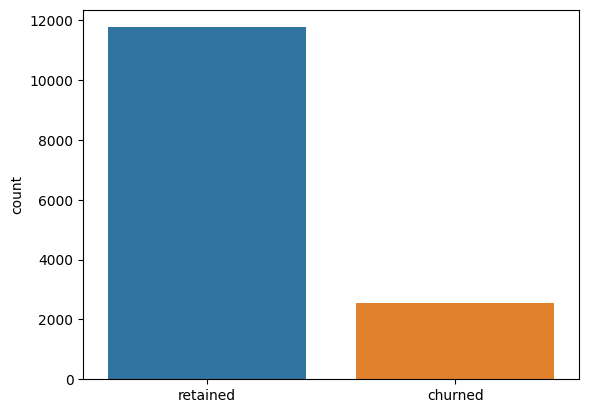

In [17]:
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [18]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [19]:
#The above cells show that the data is unbalanced. 
#Successful modelling may necessitate resampling to balance classes. 

In [20]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

(a) Define X and y

(b) Perform train/test split on (X, y)

(c) Create an object of the class associated with the algorithm to be used--in this case LogisticRegression

(d) Build an actual model using thefit method from the class associated with the algorithm to be used (using the training set)

(e) Predict with the built model using thepredict method from the class (training set and test set)

(f) Compute performance metrics (in this case, accuracy) for the training and test predictions. The metrics to be used and their interpretation will depend on the application at hand

(g) Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning

(h) Compare and Combine all best models as needed

<h2> Logistic Regression 

In [21]:
#create object of class associated with Logistic Regression 
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)

In [23]:
#Fit the model using training set
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, solver='newton-cg')

In [28]:
#Predict y test and check accuracy on predicting test set
y_predict = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)
test_accuracy

0.8244755244755245

In [30]:
#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)
train_accuracy

0.8255966430632048

#While checking for accuracy is only the first step, the well matched train/test accuracy (low variance) is a good start with no obvious over/underfitting. 

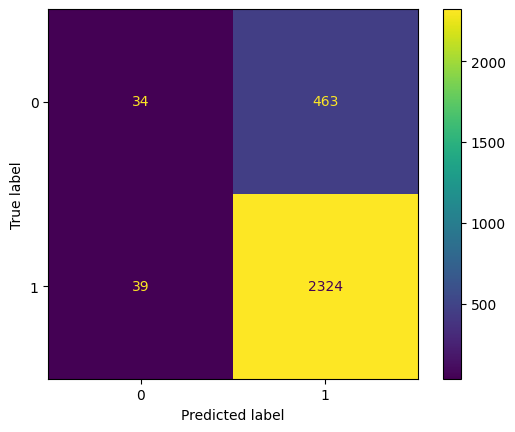

In [33]:
cm = confusion_matrix(y_test, y_predict, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm) 
                                    #, display_labels = ['no heart disease', 'heart disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
#ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
#ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax);